In [ ]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin=URL,
                                   fname='flower_photos.tgz',
                                   untar=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'flower_photos')

228813984/228813984 [==============================] - 11s 0us/step


In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [ ]:
for cl in classes:
  imgs_path = os.path.join(data_dir, cl) #go into dir with name of flower
  imgs = glob.glob(imgs_path + '/*.jpg') #find all pics in that dir (pic if ends in jpg)
  print(f"{cl}: {len(imgs)} Images")
  train, val = imgs[:round(len(imgs) * 0.8)], imgs[round(len(imgs) * 0.8):] #80-20 split into train/val datasets

  for t in train:
    if not os.path.exists(os.path.join(data_dir, 'train', cl)): #if a path of format flower_photos/train/[class_name] doesn't exist, make one
      os.makedirs(os.path.join(data_dir, 'train', cl)) #use makedirs to create train/[class_name] (mkdir would only create [class_name])
    shutil.move(t, os.path.join(data_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(data_dir, 'val', cl)): #similar process for validation data
      os.makedirs(os.path.join(data_dir, 'val', cl))
    shutil.move(v, os.path.join(data_dir, 'val', cl))


roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [ ]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')


In [ ]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [ ]:
def PlotImages(imgs):
  dim = 3 #for a 3x3 of images
  plt.figure(figsize=(10, 10))
  for i in range(dim**2):
    plt.subplot(dim, dim, i+1)
    plt.imshow(imgs[i])


In [ ]:
img_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    height_shift_range=0.15,
    width_shift_range=0.15,
    brightness_range=(0.5, 1.5),
    fill_mode='wrap'
)

train_data_gen = img_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    shuffle=True,
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.


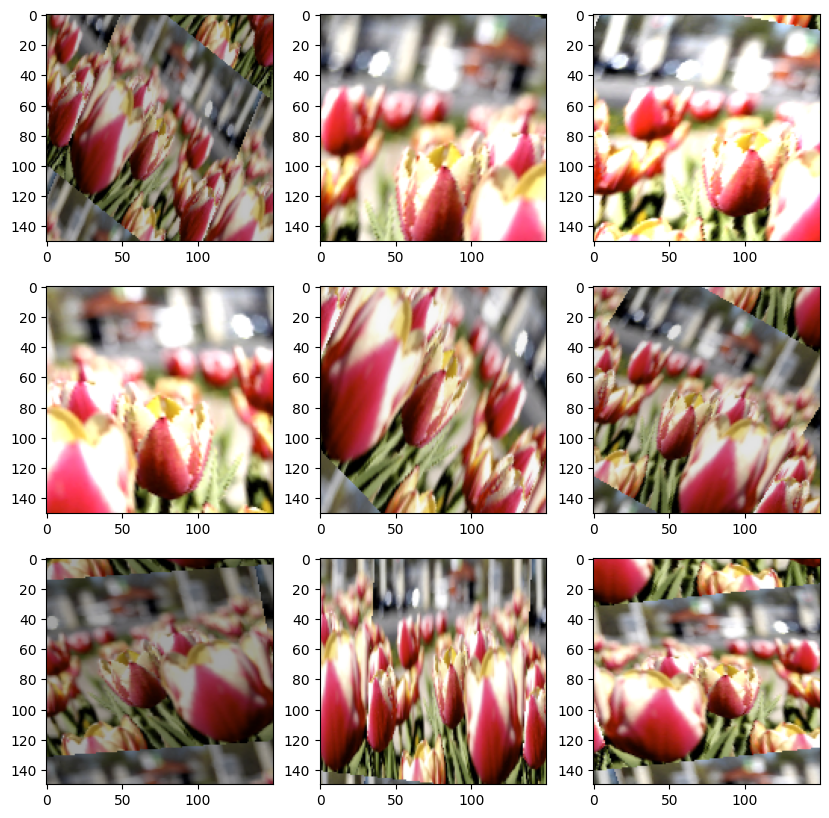

In [ ]:

viz_imgs = [train_data_gen[0][0][0] for i in range(9)]
PlotImages(viz_imgs)

In [ ]:

img_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = img_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=val_dir,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='sparse')


Found 735 images belonging to 5 classes.


In [ ]:
model = Sequential([
   Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(32, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(64, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Flatten(),

   Dropout(0.2),
   Dense(512, activation='relu'),

   Dropout(0.2),
   Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
EPOCHS = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.02)

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/50
30/30 [==============================] - 40s 839ms/step - loss: 1.5886 - accuracy: 0.3124 - val_loss: 1.2632 - val_accuracy: 0.4408
Epoch 2/50
30/30 [==============================] - 28s 917ms/step - loss: 1.2423 - accuracy: 0.4777 - val_loss: 1.2209 - val_accuracy: 0.5143
Epoch 3/50
30/30 [==============================] - 24s 794ms/step - loss: 1.1502 - accuracy: 0.5312 - val_loss: 1.1071 - val_accuracy: 0.5388
Epoch 4/50
30/30 [==============================] - 25s 830ms/step - loss: 1.0961 - accuracy: 0.5578 - val_loss: 1.0530 - val_accuracy: 0.5565
Epoch 5/50
30/30 [==============================] - 25s 828ms/step - loss: 1.0494 - accuracy: 0.5847 - val_loss: 0.9729 - val_accuracy: 0.6354
Epoch 6/50
30/30 [==============================] - 23s 782ms/step - loss: 1.0259 - accuracy: 0.5956 - val_loss: 0.9714 - val_accuracy: 0.6381
Epoch 7/50
30/30 [==============================] - 25s 825ms/step - loss: 0.9892 - accuracy: 0.6044 - val_loss: 0.9012 - val_accuracy: 0.6680

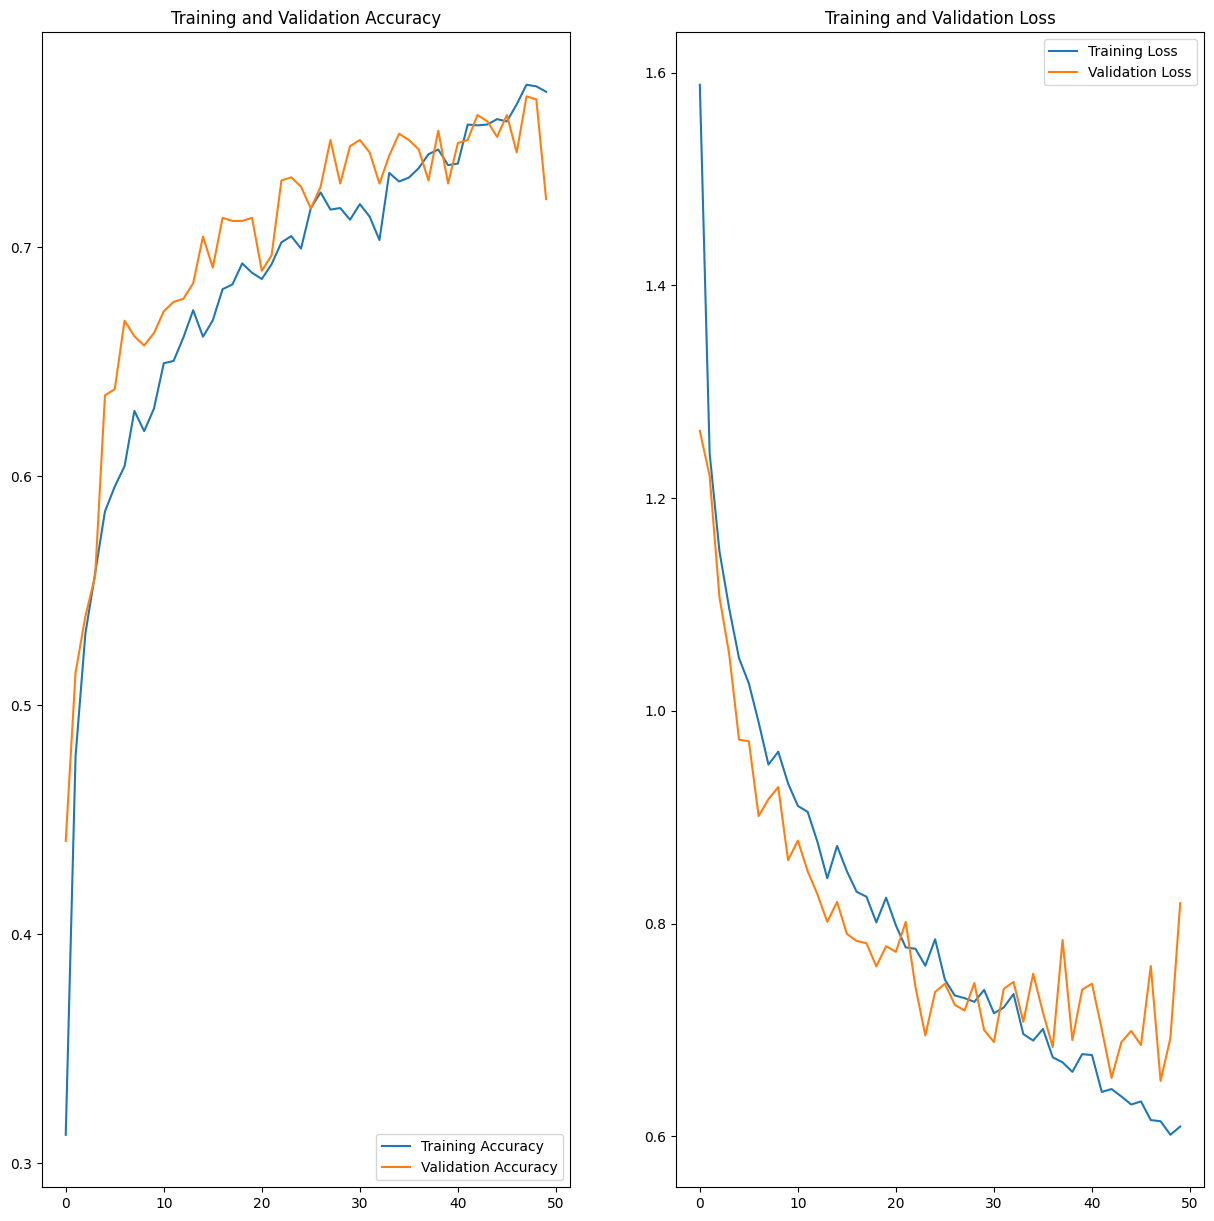

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15,15))
x_epochs = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(x_epochs, acc, label='Training Accuracy')
plt.plot(x_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(x_epochs, loss, label='Training Loss')
plt.plot(x_epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()

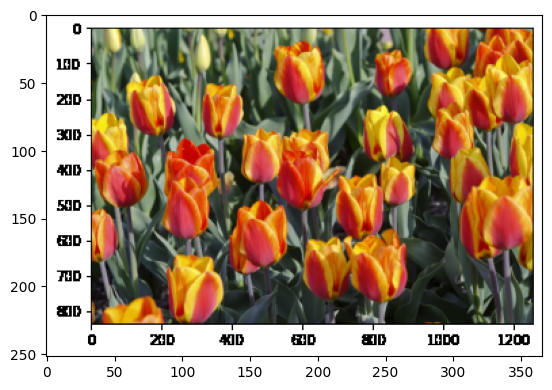

In [ ]:
tester = tf.keras.preprocessing.image.load_img('/content/download (14).png')
plt.imshow(tester)

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(tester)
input_arr = np.array([input_arr])  # Convert single image to a batch.

resized = tf.image.resize(input_arr, (150, 150))
predictions = model.predict(resized)

guess = predictions.argmax()
print(classes[guess])


1/1 [==============================] - 0s 295ms/step
tulips
